## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that we get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
print('There are {} rows in the dataset.'.format(len(df.index)))

There are 294478 rows in the dataset.


c. The number of unique users in the dataset.

In [4]:
print('There are {} unique users in the dataset.'.format(df['user_id'].nunique()))


There are 290584 unique users in the dataset.


d. The proportion of users converted.

In [5]:
print('The proportion of users converted is:',round(df.converted.mean(),2))


The proportion of users converted is: 0.12


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
misalignment = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]
print("There are {} times that new_page and treatment don't line up.".format(misalignment))

There are 3893 times that new_page and treatment don't line up.


f. Do any of the rows have missing values?

In [7]:
## Counting missing values in all rows
sum(df.apply(lambda x: sum(x.isnull().values), axis = 1)>0)

0

> As seen above, there are no missing values in any row.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:

df2 = df.copy()
df2 = df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) != False]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
print('There are {} unique users in the dataset.'.format(df2['user_id'].nunique()))

There are 290584 unique users in the dataset.


b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
import warnings
warnings.filterwarnings("ignore")

ids = df2["user_id"]
df_duplicated=df2[ids.isin(ids[ids.duplicated()])]
df_duplicated.user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

>As seen above, the duplicated user Id is 773192 and it has been duplicated twice.

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[ids.isin(ids[ids.duplicated()])]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(2893, inplace=True)
df2[ids.isin(ids[ids.duplicated()])]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
print('The probability that an individual gets converted regardless of page received is:',
      df2.converted.mean())

The probability that an individual gets converted regardless of page received is: 0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
print("The probability that a user gets converted given that he was in control group is:",
      df2.query('group =="control"').converted.mean())

The probability that a user gets converted given that he was in control group is: 0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
print("The probability that a user gets converted given that he was in control group is:",
      df2.query('group =="treatment"').converted.mean())

The probability that a user gets converted given that he was in control group is: 0.11880806551510564


d. What is the probability that an individual received the new page?

In [17]:
print("The probability that an individual lands on a new page is:",(df2.landing_page == "new_page").mean())

The probability that an individual lands on a new page is: 0.5000619442226688


In [18]:
print("The probability that an individual lands on a new page is:",(df2.landing_page == "old_page").mean())

The probability that an individual lands on a new page is: 0.4999380557773312


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

## Answer
With users given approximately the same probability for landing on either the old page or the new page, the probability that a they get converted if they're from control group is only slightly lower than the probability if they're from the treatment group. Therefore it will be risky to conclude that there's sufficient evidence that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

## Answer
**$H_{0}$**: **$P_{new}$** <= **$P_{old}$** : The old page either have a higher probability of conversion than the new page, or at least they have equal conversion probabilities

**$H_{1}$**: **$P_{new}$** > **$P_{old}$**  : The new page has a higher probability of conversion


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
#conversion rate proportion for p_new under the null hypothesis
print("The conversion rate for p_new under the null hypothesis is:",df2['converted'].mean())

The conversion rate for p_new under the null hypothesis is: 0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
#conversion rate proportion for p_old under the null hypothesis
print("The conversion rate for p_old under the null hypothesis is:",df2['converted'].mean())

The conversion rate for p_old under the null hypothesis is: 0.11959708724499628


c. What is $n_{new}$?

In [21]:
print("n_new=",df2.query("group == 'treatment'").shape[0])

n_new= 145310


d. What is $n_{old}$?

In [22]:
print("n_old=",df2.query("group == 'control'").shape[0])

n_old= 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
n_new = df2.query("group == 'treatment'").shape[0]
n_old = df2.query("group == 'control'").shape[0]
p_new = df2.converted.mean()
p_old = df2.converted.mean()
print("new_page_converted =",np.random.binomial(1, p = p_new,size = n_new))

new_page_converted = [1 0 0 ... 0 0 0]


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
print("old_page_converted =",np.random.binomial(1, p = p_old,size = n_old))

old_page_converted = [0 0 0 ... 0 0 0]


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_new_converted = np.random.binomial(1, p = p_new,size = n_new).mean()
p_old_converted = np.random.binomial(1, p = p_old,size = n_old).mean()
print("p_new-p_old = {}".format(p_new_converted-p_old_converted))


p_new-p_old = 0.001161044950981821


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
new_convert = np.random.binomial(n_new,p_new,10000)/n_new
old_convert = np.random.binomial(n_old,p_old,10000)/n_old
p_diffs = new_convert - old_convert
p_diffs

array([-0.0007318 ,  0.00199413,  0.00045194, ..., -0.00033225,
       -0.00038069,  0.00062419])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

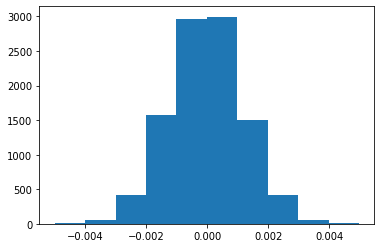

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
#Actual difference of converted rates
actual_diff = (df2[df2['group'] == "treatment"]['converted'].mean()) - (df2[df2['group'] == "control"]['converted'].mean())
actual_diff

-0.0015782389853555567

In [29]:
#Convert to numpy array and calculate the p-value
p_diffs = np.array(p_diffs)
(p_diffs >= actual_diff).mean()

0.9077

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

## Answer
- The value calculated in *j* above is the *p-value*. *p-value = 0.9077*.
- The high *p-value* indicates weak evidence against the null hypothesis, in such situations, we fail to reject the null hypothesis. 
- In this case, the high *p-value* suggests that the either the rate of user's conversion for the new page is the same with that of the old page or even worse. Therefore, it's reasonable to maintain the old page.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm
convert_old = df2.query('landing_page == "old_page" and converted == 1').count()[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').count()[0]
n_old = df2.query('landing_page =="old_page"').count()[0]
n_new = df2.query('landing_page =="new_page"').count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [31]:
from scipy.stats import norm
critical_value = norm.ppf(1-(0.05/2))
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print ("z_score = {}, p_value = {} and critical_value = {} ".format(round(z_score,2),round(p_value,2),round(critical_value,2)))

z_score = -1.31, p_value = 0.91 and critical_value = 1.96 


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

## Answer
- Basically, the z-score (also known as standard score) gives us the idea of how far a data point is from the mean.
- In addition to the fact that the p-value obtained here (p-value = 0.91) agrees with the ones found previously in j and k, the z-score(z-score = -1.31) is less than the critical value, also suggesting that we should fail to reject the null hypothesis.
- We now have more evidence that the old page is better than the new page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

## Answer
We should be performing a ****logistic regression****

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
## Adding an intercept column
df2['intercept'] = 1
df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [33]:
#Create dummies
ab_page = ['treatment', 'control']
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']
df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 25 Jan 2020   Pseudo R-squ.:               8.077e-06
Time:                        17:18:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

## Answer
- The p-value associated with the ab_page is 0.190.
- The p-value here is lower than the one found in **Part II** because here, were are using two tailed test  as opposed to the one-tailed test performed in **part II**.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

## Answer
___________________________________

There are other factors not considered in the tests that might have very significant influence on the conversion rate. For example;
- Ethnicity: people from poor countries might have relately low conversion rate, hence it's reasonble to include information about users location(Country of origin).
- Age group: Users from a younger age group might also have lower conversion rate. Excluding such information migh cause the result of the test to be biased
- Though it's reasonable to add additional information, the dataset might become more complex to analyse.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [36]:
### Create the necessary dummy variables
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country'])
df_new.head(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page,ca,uk,us
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [37]:
### Fit Your Linear Model And Obtain the Results
sm.Logit(df_new['converted'], df_new[['intercept','us','ca']]).fit().summary() ## We first consider us and ca

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 25 Jan 2020   Pseudo R-squ.:               1.521e-05
Time:                        17:18:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
us            -0.0099      0.013     -0.746      0.456      -0.036       0.016
ca            -0.0507      0.028     -1.786      0.074      -0.106       0.005
==============================================================================
"""

In [38]:
sm.Logit(df_new['converted'], df_new[['intercept','uk','ca']]).fit().summary() ## now we consider uk and ca

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 25 Jan 2020   Pseudo R-squ.:               1.521e-05
Time:                        17:18:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
uk             0.0099      0.013      0.746      0.456      -0.016       0.036
ca            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

In [39]:
sm.Logit(df_new['converted'], df_new[['intercept','uk','us']]).fit().summary()## now we consider uk and us

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 25 Jan 2020   Pseudo R-squ.:               1.521e-05
Time:                        17:18:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
uk             0.0507      0.028      1.786      0.074      -0.005       0.106
us             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

>Considering all the cases above, we see that the resulting p-values for countries are still greater than 0.05, another evidence in favour of the null hypothesis. Thus, we still fail to reject the null hypothesis. This is an indication that user's country of origin has no significant influenceon the conversion rate. Even if there is a significant influence, then it's still in favour of the old page.

## Resources
1. [What is a Z score What is a p-value](http://resources.esri.com/help/9.3/arcgisdesktop/com/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm)
2. [Power of a Hypothesis Test](https://stattrek.com/hypothesis-test/power-of-test.aspx)
3. [Python and R Tips](https://cmdlinetips.com/2018/01/how-to-get-unique-values-from-a-column-in-pandas-data-frame/)
4. [LOGISTIC REGRESSION ANALYSIS | STATA ANNOTATED OUTPUT](https://stats.idre.ucla.edu/stata/output/logistic-regression-analysis/)